# 문제정의
* the International Airline Passengers
* 년 단위 항공기 이용 승객 데이터를 이용하여 다음 번 승객의 수를 예측해봅니다.
* Time-series Regression 문제입니다.

# 데이터 준비
* 웹에 공개된 the International Airline Passengers의 csv 형태의 데이터를 이용합니다.
* https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# 데이터는 월별 항공 승객 수를 가지고 있습니다. (천단위 절삭)
path_data = "./datasets/international-airline-passengers.csv"
columns = ['Month', 'Passengers']
df_data = pd.read_csv(path_data, names=columns, skiprows=1, nrows=144)
df_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


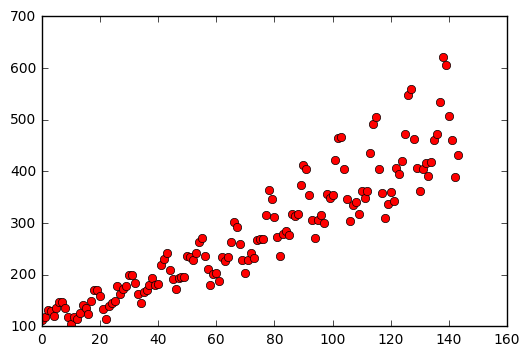

In [3]:
plt.plot(df_data["Passengers"], 'ro')
#plt.plot(df_data["Passengers"])
plt.show()

(142, 2)


,x,y
0,112,118
1,118,132
2,132,129
3,129,121
4,121,135


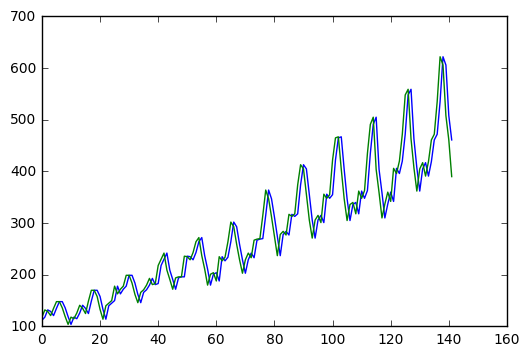

In [4]:
# 한달 후 승객 수를 추측해야 하므로 y값은 x값의 한달 후 데이터가 되도록 만듭니다.
x = df_data["Passengers"][0:142].reset_index(drop=True)
y = df_data["Passengers"][1:143].reset_index(drop=True)
xy = pd.concat([x, y], keys=["x", "y"], axis=1)
print xy.shape
plt.plot(xy)
xy.head()

In [5]:
# 훈련 데이터 셋은 100개(약 70%), 테스트 데이터 셋은 42개(약 30%)를 사용하도록 만듭니다.
train_data = xy[:][0:100].reset_index(drop=True)
test_data = xy[:][100:xy.shape[0]].reset_index(drop=True)
print train_data.shape
print test_data.shape

(100, 2)
(42, 2)


# 알고리즘 선택
* 시계열 데이터 셋 예측을 위해 RNN의 한 종류인 LSTM을 사용해 보도록 합니다.

In [6]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_sdata = scaler.fit_transform(train_data).astype('float32')
test_sdata = scaler.fit_transform(test_data).astype('float32')
print type(train_sdata), train_sdata.shape
print type(test_sdata), test_sdata.shape

<type 'numpy.ndarray'> (100, 2)
<type 'numpy.ndarray'> (42, 2)


In [7]:
import tensorflow as tf
from tensorflow.python.framework import dtypes

lstm_size = 1
time_step_size = 1
batch_size = 1

# LSTM
lstm_cells = []
lstm_cell1 = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, state_is_tuple=True)
lstm_cells.append(lstm_cell1)

stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

In [8]:
train_x = train_sdata[:, 0].reshape(-1, 1)
print train_x.shape
X_split = tf.split(0, time_step_size, train_x)
print X_split

outputs, states = tf.nn.rnn(stacked_lstm, X_split, dtype=dtypes.float32)
print outputs

(100, 1)
[<tf.Tensor 'split:0' shape=(100, 1) dtype=float32>]
[<tf.Tensor 'RNN/MultiRNNCell/Cell0/BasicLSTMCell/mul_2:0' shape=(100, 1) dtype=float32>]


In [9]:
# logits = tf.reshape(tf.concat(1, outputs), [-1, lstm_size])
# print logits

In [10]:
train_y = train_sdata[:, 1]
targets = tf.reshape(train_y, [-1])
print targets

Tensor("Reshape:0", shape=(100,), dtype=float32)


In [11]:
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
print time_step_size * batch_size
print W
y = W * outputs
print y


1
Tensor("Variable/read:0", shape=(1,), dtype=float32)
Tensor("mul:0", shape=(1, 100, 1), dtype=float32)


In [12]:
loss = tf.reduce_mean(tf.square(targets - y))
optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

step: 0, loss: 0.205409
step: 1000, loss: 0.057833
step: 2000, loss: 0.057829
step: 3000, loss: 0.057827
step: 4000, loss: 0.057826
step: 5000, loss: 0.057826
step: 6000, loss: 0.057826
step: 7000, loss: 0.057826
step: 8000, loss: 0.057826
step: 9000, loss: 0.057826
<type 'numpy.ndarray'> (1, 100, 1)


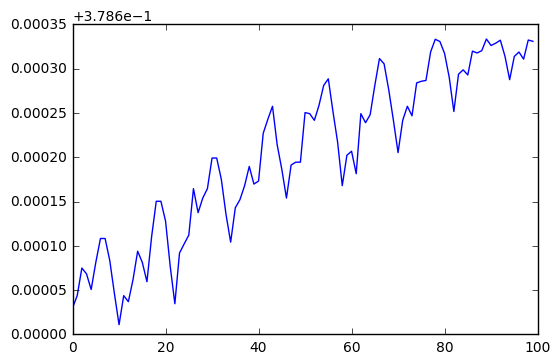

In [14]:
# Launch the graph in a session
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in xrange(10000):
        sess.run(train)
        if (step % 1000 == 0):
            print "step: %d, loss: %f" % (step, sess.run(loss))
    
    predict_y = sess.run(y)
#     predict_y = predict_y.reshape(-1, 1)
    print type(predict_y), predict_y.shape
    plt.plot(predict_y[0][:])
    

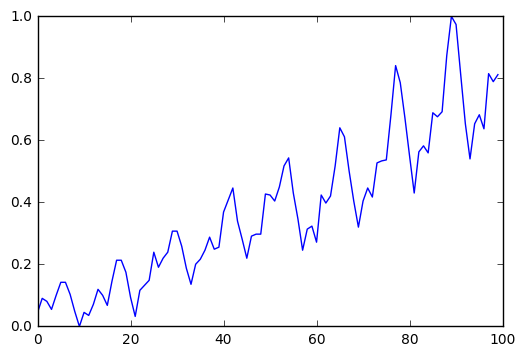

In [17]:
    plt.plot(train_y)

In [103]:
import numpy as np
from sklearn import preprocessing
np_data = df_data.values[:, 1].astype('float32').reshape(-1, 1)

# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(np_data)

In [107]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
x, y = create_dataset(np_data)
print x[1], y[1]
len(x)
# for i in range(len(x)):
#     print x[i], y[i]

[ 118.] 132.0


142

<function matplotlib.pyplot.show>

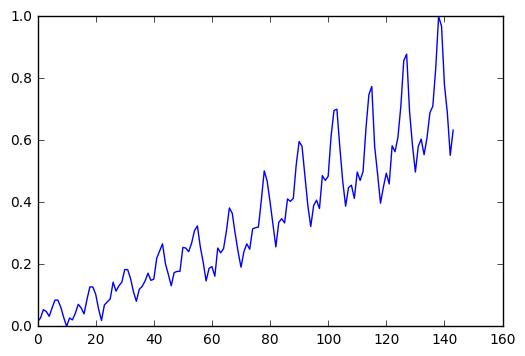

In [78]:
plt.plot(dataset)
plt.show

In [ ]:
from tensorflow.python.framework import dtypes

lstm_size = char_vocab_size  # 1 hot coding (one of 4)
time_step_size = 4  # 'hell' -> predict 'ello'
batch_size = 1  # one sample

# LSTM
lstm_cells = []
lstm_cell1 = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, state_is_tuple=True)
lstm_cell2 = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, state_is_tuple=True)
lstm_cells.append(lstm_cell1)
lstm_cells.append(lstm_cell2)
stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

X_split = tf.split(0, time_step_size, x_data)
print(X_split)
outputs, states = tf.nn.rnn(stacked_lstm, X_split, dtype=dtypes.float32)

logits = tf.reshape(tf.concat(1, outputs), [-1, lstm_size])
targets = tf.reshape(sample[1:], [-1])
weights = tf.ones([time_step_size * batch_size])

loss = tf.nn.seq2seq.sequence_loss_by_example([logits], [targets], [weights])
cost = tf.reduce_sum(loss) / batch_size
train_op = tf.train.AdamOptimizer(0.01).minimize(cost)

In [ ]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    for i in range(200):
        sess.run(train_op)
        result = sess.run(tf.arg_max(logits, 1))
        print("%r, %r" % (result, [char_rdic[t] for t in result]))

In [ ]:
# 알고리즘선택
# 실험평가